## Bagian 1: Import Library dan Setup Device

In [33]:
import os
import shutil
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

import time
import copy

import matplotlib.pyplot as plt
import numpy as np

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device yang digunakan: {device}")

Device yang digunakan: cpu


## Bagian 2: Split Dataset ke Train dan Val

In [11]:
base_dir = '/content/brain_tumor_dataset'

train_dir = '/content/brain_tumor_dataset_train'
val_dir = '/content/brain_tumor_dataset_val'

for folder in [train_dir, val_dir]:
    os.makedirs(os.path.join(folder, 'no'), exist_ok=True)
    os.makedirs(os.path.join(folder, 'yes'), exist_ok=True)

def split_data(class_name):
    class_dir = os.path.join(base_dir, class_name)
    images = os.listdir(class_dir)
    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

    for img in train_imgs:
        src = os.path.join(class_dir, img)
        dst = os.path.join(train_dir, class_name, img)
        shutil.copy(src, dst)

    for img in val_imgs:
        src = os.path.join(class_dir, img)
        dst = os.path.join(val_dir, class_name, img)
        shutil.copy(src, dst)

split_data('no')
split_data('yes')

print("Dataset berhasil dipisah menjadi train dan val.")

Dataset berhasil dipisah menjadi train dan val.


## Bagian 3: Definisikan Transformasi dan Load Dataset

In [13]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

image_datasets = {
    'train': datasets.ImageFolder(root=train_dir, transform=data_transforms['train']),
    'val': datasets.ImageFolder(root=val_dir, transform=data_transforms['val'])
}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f"Kelas: {class_names}")
print(f"Jumlah data train: {dataset_sizes['train']}")
print(f"Jumlah data val: {dataset_sizes['val']}")

Kelas: ['no', 'yes']
Jumlah data train: 202
Jumlah data val: 51


## Bagian 4: Buat Model CNN dengan Transfer Learning (ResNet18)

In [15]:
model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

## Bagian 5: Definisikan Loss dan Optimizer

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Bagian 6: Fungsi Training dan Validasi

In [17]:
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, device, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-'*20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training selesai dalam {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Akurasi validasi terbaik: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model


## Bagian 7: Mulai Training

In [18]:
model_trained = train_model(model, criterion, optimizer, dataloaders, dataset_sizes, device, num_epochs=5)

Epoch 1/5
--------------------
train Loss: 0.7386 Acc: 0.7525
val Loss: 0.8291 Acc: 0.6078
Epoch 2/5
--------------------
train Loss: 0.4750 Acc: 0.8317
val Loss: 5.0927 Acc: 0.3922
Epoch 3/5
--------------------
train Loss: 0.2927 Acc: 0.8663
val Loss: 0.7324 Acc: 0.7451
Epoch 4/5
--------------------
train Loss: 0.1499 Acc: 0.9455
val Loss: 1.3103 Acc: 0.7843
Epoch 5/5
--------------------
train Loss: 0.0963 Acc: 0.9752
val Loss: 0.6268 Acc: 0.8627
Training selesai dalam 6m 1s
Akurasi validasi terbaik: 0.8627


# Analisis Hasil Training

Berikut adalah analisis hasil training berdasarkan log epoch yang diberikan:

---

### Interpretasi Hasil Training

| Epoch | Train Loss | Train Acc | Val Loss | Val Acc |
| ----- | ---------- | --------- | -------- | ------- |
| 1     | 0.7386     | 75.25%    | 0.8291   | 60.78%  |
| 2     | 0.4750     | 83.17%    | 5.0927   | 39.22%  |
| 3     | 0.2927     | 86.63%    | 0.7324   | 74.51%  |
| 4     | 0.1499     | 94.55%    | 1.3103   | 78.43%  |
| 5     | 0.0963     | 97.52%    | 0.6268   | 86.27%  |

---

### Penjelasan Tiap Metrik

- **Train Loss** menurun signifikan dari 0.7386 ke 0.0963, ini berarti model makin baik "belajar" memetakan input ke label pada data training.
- **Train Accuracy** naik dari 75.25% ke 97.52%, menunjukkan model semakin tepat dalam mengklasifikasi data training.
- **Val Loss** dan **Val Accuracy** mengalami sedikit fluktuasi:
  - Pada epoch ke-2, val loss melonjak drastis (5.0927) dan akurasi turun (39.22%). Ini bisa jadi karena model sempat mengalami **overfitting** atau kesulitan pada batch tertentu.
  - Namun pada epoch berikutnya, val loss turun kembali dan val accuracy naik hingga mencapai 86.27%, menunjukkan bahwa model akhirnya bisa **menggeneralisasi** lebih baik ke data validasi.

---

### Kesimpulan

- Model berhasil **belajar dengan baik** pada data training (train loss menurun dan akurasi meningkat).
- Pada epoch ke-2 sempat terjadi **fluktuasi performa validasi** (kemungkinan batch yang sulit atau overfitting sementara), namun performa kembali membaik di epoch berikutnya.
- Pada epoch terakhir, val accuracy mencapai **86.27%**, yang merupakan hasil yang cukup baik untuk task **deteksi tumor otak** dari dataset citra.
- Tidak ada indikasi **overfitting berat**, karena val loss dan val accuracy membaik di akhir training.
- Proses training berlangsung **efisien** (~6 menit untuk 5 epoch), cukup cepat mengingat model yang digunakan adalah **ResNet18** dan ukuran dataset.

---

### Saran Pengembangan

- Menambah jumlah epoch untuk mencoba meningkatkan performa.
- Mencoba **augmentasi data** atau tuning hyperparameter.
- Melakukan evaluasi model di dataset **test yang benar-benar terpisah**.
- Menyimpan model dan membuat aplikasi prediksi untuk deployment.

---

## Visualisasi Akhir

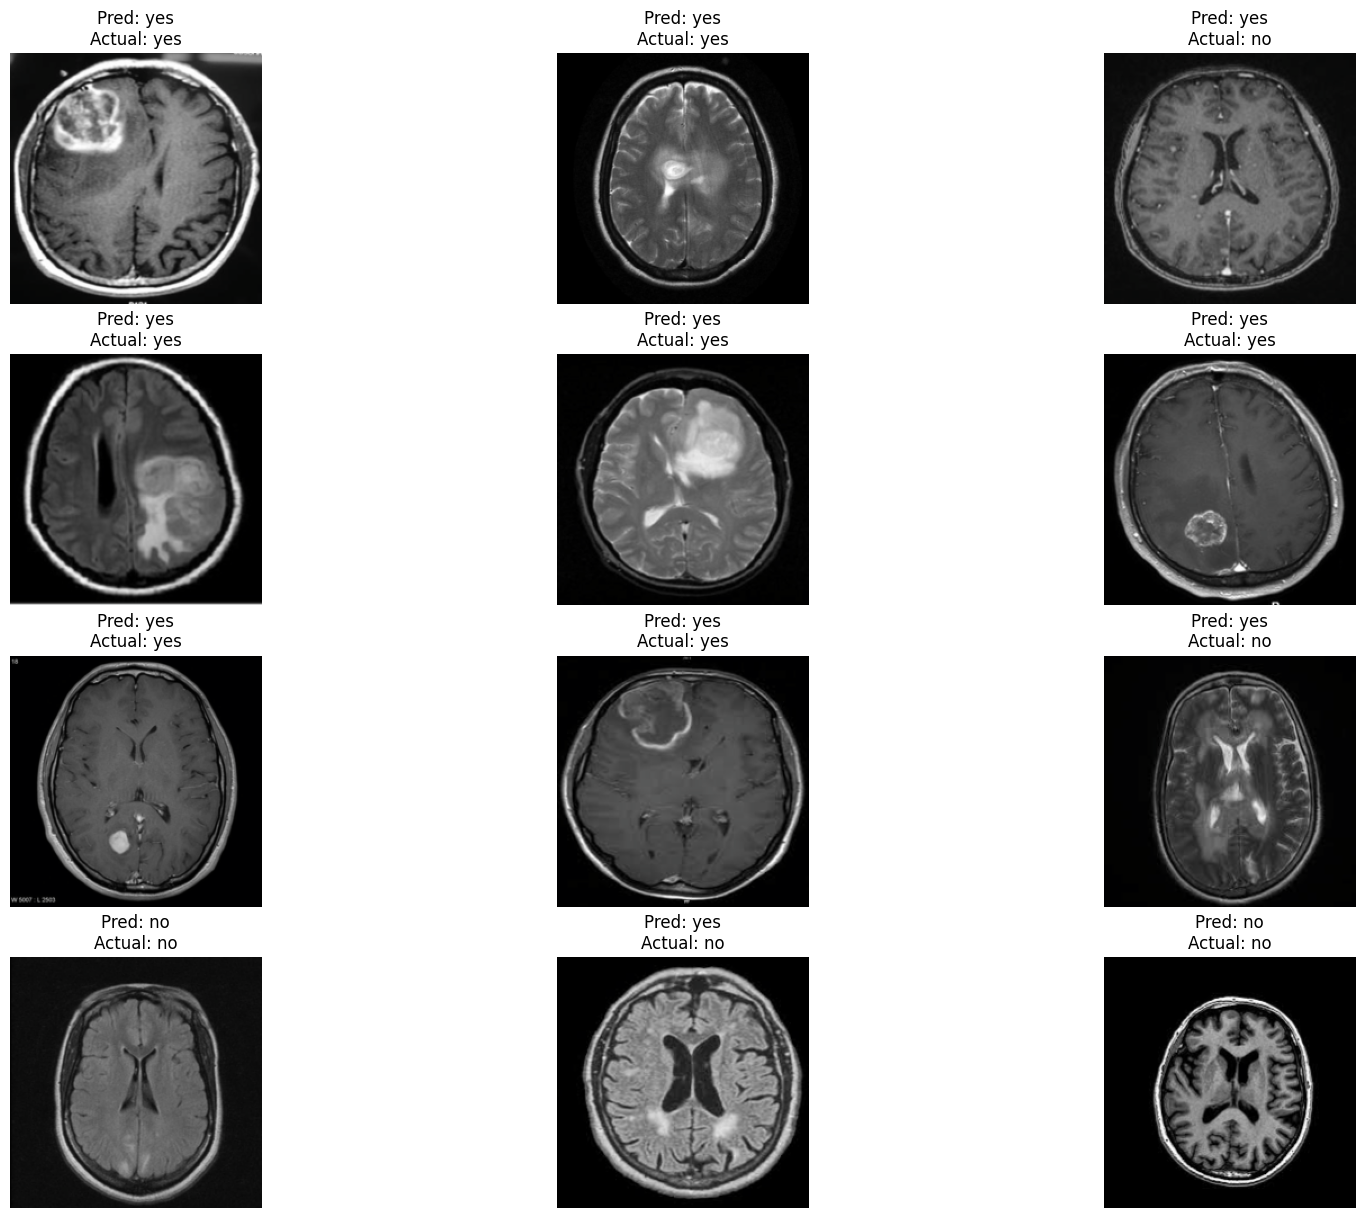

In [38]:
def imshow(inp, title=None):
    """Imshow untuk tensor gambar, normalisasi dibalik."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def visualize_model(model, dataloader, class_names, device, num_images=6):
    model.eval()
    images_so_far = 0

    plt.figure(figsize=(20, 15))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                plt.subplot(num_images//3, 3, images_so_far)
                title = f'Pred: {class_names[preds[j]]}\nActual: {class_names[labels[j]]}'
                imshow(inputs.cpu().data[j], title=title)

                if images_so_far == num_images:
                    plt.show()
                    return
    plt.show()
visualize_model(model_trained, dataloaders['val'], class_names, device, num_images=12)